
# Vocal separation

This notebook demonstrates a simple technique for separating vocals (and
other sporadic foreground signals) from accompanying instrumentation.

<div class="alert alert-danger"><h4>Warning</h4><p>This example is primarily of historical interest, and we do not recommend
    this as a competitive method for vocal source separation.
    For a more recent treatment of vocal and music source separation, please
    refer to [Open Source Tools & Data for Music Source Separation](https://source-separation.github.io/tutorial/landing.html) [1]_.</p></div>

This is based on the "REPET-SIM" method of [Rafii and Pardo, 2012](http://www.cs.northwestern.edu/~zra446/doc/Rafii-Pardo%20-%20Music-Voice%20Separation%20using%20the%20Similarity%20Matrix%20-%20ISMIR%202012.pdf)
[2]_, but includes a couple of modifications and extensions:

    - FFT windows overlap by 1/4, instead of 1/2
    - Non-local filtering is converted into a soft mask by Wiener filtering.
      This is similar in spirit to the soft-masking method used by [Fitzgerald, 2012](http://arrow.dit.ie/cgi/viewcontent.cgi?article=1086&context=argcon)
      [3]_,
      but is a bit more numerically stable in practice.

.. [1] Manilow, Ethan, Prem Seetharman, and Justin Salamon.
    "Open source tools & data for music source separation."
    2020.

.. [2] Rafii, Zafar, and Bryan Pardo.
    "Music/Voice Separation Using the Similarity Matrix."
    In ISMIR, pp. 583-588. 2012.

.. [3] FitzGerald, Derry.
    "Vocal separation using nearest neighbours and median filtering."
    23rd IET Irish Signals and Systems Conference, Maynooth.  (2012): 98-98.


In [2]:
# Code source: Brian McFee
# License: ISC

##################
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

import librosa

Load an example with vocals.



In [3]:
# Define a class to load our own custom songs

class AudioSample:
    def __init__(self, name, path, start_sec, end_sec, duration=120):
        self.name = name
        self.path = path
        self.duration = duration
        self.y = None
        self.sr = None
        self.S_full = None
        self.phase = None
        self.start_sec = start_sec
        self.end_sec = end_sec

    def load(self):
        self.y, self.sr = librosa.load(self.path, duration=self.duration)
        self.S_full, self.phase = librosa.magphase(librosa.stft(self.y))

    def play(self, start_sec, end_sec):
        if self.y is not None and self.sr is not None:
            return Audio(data=self.y[start_sec*self.sr:end_sec*self.sr], rate=self.sr)
        else:
            print("Audio not loaded. Call load() first.")
            return None

# Define your samples
samples = {
    "MedleyDB_sample": AudioSample("MedleyDB_sample", '/media/allentao/One Touch/APS360/MedleyDB_sample/Audio/Phoenix_ScotchMorris/Phoenix_ScotchMorris_MIX.wav', 10, 15),
    "MedleyDB_V2": AudioSample("MedleyDB_V2", '/media/allentao/One Touch/APS360/MedleyDB_V2/V2/BarefootSisters_RedJetta/BarefootSisters_RedJetta_MIX.wav', 15, 35)
}

# Load and play all samples
for sample_name, sample in samples.items():
    print(f"Loading and playing sample: {sample_name}")
    sample.load()
    audio = sample.play(sample.start_sec, sample.end_sec)
    display(audio)

Loading and playing sample: MedleyDB_sample


Loading and playing sample: MedleyDB_V2


Choose which piece you want to run extraction on

In [4]:
S_full, phase = librosa.magphase(librosa.stft(samples["MedleyDB_V2"].y))
y, sr = librosa.load(samples["MedleyDB_V2"].path, duration=120)
start_sec, end_sec = samples["MedleyDB_V2"].start_sec, samples["MedleyDB_V2"].end_sec

In [ ]:
# # If you want to load the default example from the docs
# # otherwise don't run this cell
# y, sr = librosa.load(librosa.ex('fishin'), duration=120)

# # MedleyDB_sample: non vocal example, results are very scratchy but not bad
# #y, sr = librosa.load('/media/allentao/One Touch/APS360/MedleyDB_sample/Audio/Phoenix_ScotchMorris/Phoenix_ScotchMorris_MIX.wav', duration=120)

# # MedleyDB_V2 sample: vocal example: does a pretty good job getting the voiceline
# # background music has some sound signatures from the melody
# # y, sr = librosa.load('/media/allentao/One Touch/APS360/MedleyDB_V2/V2/BarefootSisters_RedJetta/BarefootSisters_RedJetta_MIX.wav', duration=120)



# # And compute the spectrogram magnitude and phase
# S_full, phase = librosa.magphase(librosa.stft(y))

# # Play back a 5-second excerpt with vocals

# Audio(data=y[10*sr:15*sr], rate=sr)
# # Audio(data=y[10*sr:15*sr], rate=sr)
# # Audio(data=y[15*sr:20*sr], rate=sr)

Plot a 5-second slice of the spectrum



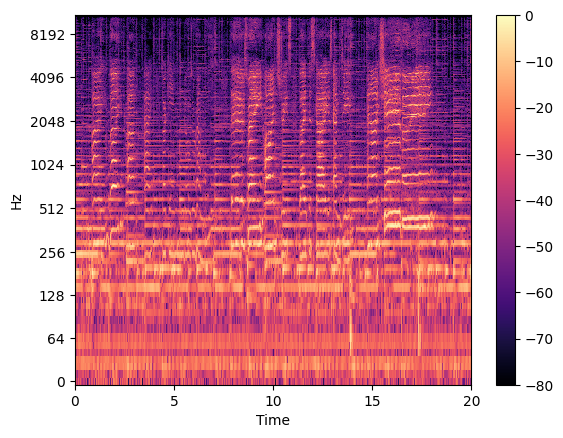

In [5]:
idx = slice(*librosa.time_to_frames([start_sec, end_sec], sr=sr))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax)
fig.colorbar(img, ax=ax)

The wiggly lines above are due to the vocal component.
Our goal is to separate them from the accompanying
instrumentation.




In [6]:
# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimum
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)

The raw filter output can be used as a mask,
but it sounds better if we use soft-masking.



In [7]:
# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

Plot the same slice, but separated into its foreground and background



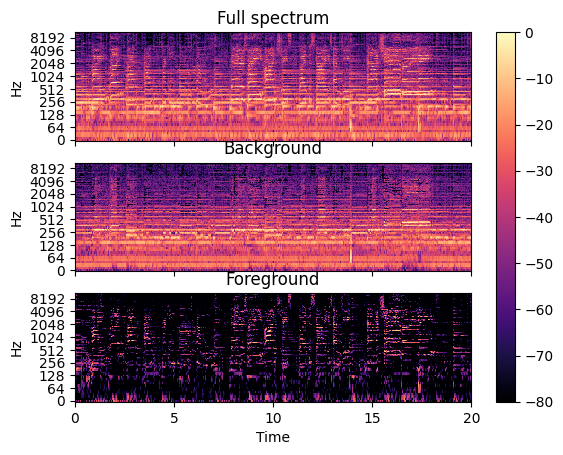

In [8]:
# sphinx_gallery_thumbnail_number = 2

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
img = librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[0])
ax[0].set(title='Full spectrum')
ax[0].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[1])
ax[1].set(title='Background')
ax[1].label_outer()

librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, ax=ax[2])
ax[2].set(title='Foreground')
fig.colorbar(img, ax=ax)

Recover the foreground audio from the masked spectrogram.
To do this, we'll need to re-introduce the phase information
that we had previously set aside.



In [9]:
y_foreground = librosa.istft(S_foreground * phase)
# Play back a 5-second excerpt with vocals
Audio(data=y_foreground[samples["MedleyDB_V2"].start_sec*sr:samples["MedleyDB_V2"].end_sec*sr], rate=sr)

Attempt to generate an accompaniment track from the background

In [10]:
# generate background audio
y_background = librosa.istft(S_background * phase)
# Play back a 5-second excerpt with vocals
Audio(data=y_background[samples["MedleyDB_V2"].start_sec*sr:samples["MedleyDB_V2"].end_sec*sr], rate=sr)

Now, convert both the extracted melody and accompaniment into piano MIDI

In [12]:
import pretty_midi

def audio_to_midi(y, sr, filename):
    # Extract the pitch using librosa's piptrack function
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)

    # Create a PrettyMIDI object
    midi = pretty_midi.PrettyMIDI()

    # Create an Instrument instance for a piano (MIDI program 0)
    piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    piano = pretty_midi.Instrument(program=piano_program)

    # Iterate over all time frames
    for t in range(pitches.shape[1]):
        # Find the frequency bin with the highest magnitude in this time frame
        index = magnitudes[:, t].argmax()
        pitch = pitches[index, t]

        # If the magnitude is low, assume it's silence
        if magnitudes[index, t] < 1.0:
            continue

        # Convert frequency to MIDI note
        midi_note = pretty_midi.hz_to_note_number(pitch)

        # Create a Note instance for this MIDI note
        note = pretty_midi.Note(velocity=100, pitch=int(midi_note), start=t/100.0, end=(t+1)/100.0)

        # Add it to our piano instrument
        piano.notes.append(note)

    # Add the piano instrument to the PrettyMIDI object
    midi.instruments.append(piano)

    # Write out the MIDI data
    midi.write(filename)

In [13]:
# Generate foreground and background audio
y_foreground = librosa.istft(S_foreground * phase)
y_background = librosa.istft(S_background * phase)

# Convert the 5-second interval of the foreground and background audio to MIDI
audio_to_midi(y_foreground[samples["MedleyDB_V2"].start_sec*sr:samples["MedleyDB_V2"].end_sec*sr], sr, 'foreground.mid')
audio_to_midi(y_background[samples["MedleyDB_V2"].start_sec*sr:samples["MedleyDB_V2"].end_sec*sr], sr, 'background.mid')

This is done pretty poorly, let's try Spotify's `basic-pitch`

In [14]:
# First, we need to export the extracted melody and accompaniment audio to audio files 
# that we can pass to Spotify

import soundfile as sf

# Write the foreground and background audio to WAV files
sf.write('foreground.wav', y_foreground[samples["MedleyDB_V2"].start_sec*sr:samples["MedleyDB_V2"].end_sec*sr], sr)
sf.write('background.wav', y_background[samples["MedleyDB_V2"].start_sec*sr:samples["MedleyDB_V2"].end_sec*sr], sr)

In [15]:
from basic_pitch.inference import predict_and_save
from basic_pitch import ICASSP_2022_MODEL_PATH
import os
import shutil

# make spotify directory
try:
    shutil.rmtree("./spotify/")
except:
    pass
os.makedirs("./spotify/", exist_ok=True)

# Generate MIDI files for foreground.wav and background.wav
predict_and_save(["foreground.wav"], "./spotify/", True, True, False, False)
predict_and_save(["background.wav"], "./spotify/", True, True, False, False)

# Upon close listening, both the mid and the wav are quite similar
# You have to crank the volume way up for the mid
# Spotify does quite a good job!!


2023-07-11 10:50:00.414061: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-11 10:50:00.559050: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-11 10:50:00.559921: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 10:50:01.499353: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-11 10:50:02.443503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Do


Predicting MIDI for foreground.wav...


  Creating midi...
  💅 Saved to spotify/foreground_basic_pitch.mid


  Creating midi sonification...
  🎧 Saved to spotify/foreground_basic_pitch.wav

Predicting MIDI for background.wav...


  Creating midi...
  💅 Saved to spotify/background_basic_pitch.mid


  Creating midi sonification...
  🎧 Saved to spotify/background_basic_pitch.wav


Next, we have to come up with a **Quantitative** and **Qualitative** measure to evaluate our baseline model. Hopefully this could be extended to our main model as well since it is always tricky to evaluate something that is generative

Qualitatively, on the *BarefootSisters_RedJetta_MIX* it captures the melody pretty well, with interesting musical ideas that I did not see (which nonetheless make sense) such as the minor sixth jump (C -> A flat -> C) at the end, which is not explicit in the singer's voiceline when she says "Turkey". It kinda falls apart when there is a multiple voice harmony in the second half of the audio snippet.
The accompaniment part clearly sounds like a backing track, supporting the melody and lower in pitch, however it deviates substantially from convential piano backing tracks, with lots of rapid trills in the left hand, and a very tricky part to execute technically.

Quantitatively, we can perform some form of comparison against the pre-separated audio stems of the song from the MedleyDB V2 dataset. The top-most stem is the melody, so we can perform comparison between the melody part of the piano with the first stem. Note that our melody extraction and midi conversion does not distort the time, so during this comparison all music files remain perfectly synced as they both came from the same input song.

In [24]:
# Compare melody stem midi file and out foreground basic pitch midi file to give quantative measure of how different they are
# The lower the better
import librosa
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def audio_similarity(file1, file2, start_time1=None, end_time1=None, start_time2=None, end_time2=None):
    # Load the audio files
    y1, sr1 = librosa.load(file1)
    y2, sr2 = librosa.load(file2)

    # If start and end times are specified, convert them to sample indices and slice the audio data
    if start_time1 is not None and end_time1 is not None:
        start_sample1 = int(start_time1 * sr1)
        end_sample1 = int(end_time1 * sr1)
        y1 = y1[start_sample1:end_sample1]

    if start_time2 is not None and end_time2 is not None:
        start_sample2 = int(start_time2 * sr2)
        end_sample2 = int(end_time2 * sr2)
        y2 = y2[start_sample2:end_sample2]

    # Compute the Mel-spectrogram of each audio file
    S1 = librosa.feature.melspectrogram(y=y1, sr=sr1)
    S2 = librosa.feature.melspectrogram(y=y2, sr=sr2)

    # Zero-pad the smaller spectrogram to match the dimensions of the larger one
    if S1.shape[1] < S2.shape[1]:
        S1 = np.pad(S1, ((0, 0), (0, S2.shape[1] - S1.shape[1])))
    elif S1.shape[1] > S2.shape[1]:
        S2 = np.pad(S2, ((0, 0), (0, S1.shape[1] - S2.shape[1])))

    # Compute the cosine similarity between the two Mel-spectrograms
    similarity = cosine_similarity(S1.T, S2.T) # transpose matrices to get vector-wise cosine similarities

    # Take the mean of all the elements in the similarity matrix
    mean_similarity = np.mean(similarity)

    return mean_similarity

In [27]:
# Compare generated versus ground truth melody
similarity = audio_similarity('/media/allentao/One Touch/APS360/MedleyDB_V2/V2/BarefootSisters_RedJetta/BarefootSisters_RedJetta_STEMS/BarefootSisters_RedJetta_STEM_01.wav', './spotify/foreground_basic_pitch.wav', \
                              start_time1=samples["MedleyDB_V2"].start_sec, end_time1=samples["MedleyDB_V2"].end_sec)
print('Similarity:', similarity)

Similarity: 0.094958104


In [30]:
# Try using chroma similarity instead, the above metric reports a higher match for the background to the ground truth melody than the 
# generated melody to the ground truth melody
import librosa
import numpy as np
from scipy.spatial.distance import cdist

def chroma_similarity(file1, file2, start_time1=None, end_time1=None, start_time2=None, end_time2=None):
    # Load the audio files
    y1, sr1 = librosa.load(file1)
    y2, sr2 = librosa.load(file2)

    # If start and end times are specified, convert them to sample indices and slice the audio data
    if start_time1 is not None and end_time1 is not None:
        start_sample1 = int(start_time1 * sr1)
        end_sample1 = int(end_time1 * sr1)
        y1 = y1[start_sample1:end_sample1]

    if start_time2 is not None and end_time2 is not None:
        start_sample2 = int(start_time2 * sr2)
        end_sample2 = int(end_time2 * sr2)
        y2 = y2[start_sample2:end_sample2]

    # Compute the chroma features of each audio file
    chroma1 = librosa.feature.chroma_stft(y=y1, sr=sr1)
    chroma2 = librosa.feature.chroma_stft(y=y2, sr=sr2)

    # Adjust for potential key differences by rotating the chroma vectors to find the best alignment
    max_corr = -np.inf
    for shift in range(0, 12):
        shifted_chroma2 = np.roll(chroma2, shift, axis=0)
        corr = 1 - cdist(chroma1.T, shifted_chroma2.T, 'cosine')  # This will give us cosine similarity
        corr = corr[corr > 0].mean()  # Taking mean of positive correlations only
        if corr > max_corr:
            max_corr = corr

    return max_corr

In [33]:
similarity = chroma_similarity('/media/allentao/One Touch/APS360/MedleyDB_V2/V2/BarefootSisters_RedJetta/BarefootSisters_RedJetta_STEMS/BarefootSisters_RedJetta_STEM_01.wav', './spotify/foreground_basic_pitch.wav', \
                              start_time1=samples["MedleyDB_V2"].start_sec, end_time1=samples["MedleyDB_V2"].end_sec)
print('Similarity:', similarity)

Similarity: 0.3834335700705428


Probably need to convert to midi and do notewise comparison. The above metrics simply doesn't penalize wrong notes enough, so if I submit "black midi" then it will get a much higher similarity regardless of being the correct melody or not

In [34]:
# Note this is a LOT better than the extracted melody then performing midi
predict_and_save(["/media/allentao/One Touch/APS360/MedleyDB_V2/V2/BarefootSisters_RedJetta/BarefootSisters_RedJetta_STEMS/BarefootSisters_RedJetta_STEM_01.wav"], "./spotify/", True, False, False, False)


Predicting MIDI for /media/allentao/One Touch/APS360/MedleyDB_V2/V2/BarefootSisters_RedJetta/BarefootSisters_RedJetta_STEMS/BarefootSisters_RedJetta_STEM_01.wav...


  Creating midi...
  💅 Saved to spotify/BarefootSisters_RedJetta_STEM_01_basic_pitch.mid


In [55]:
import pretty_midi
import librosa
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy import interpolate

def midi_similarity(file1, file2, start_time1=None, end_time1=None, start_time2=None, end_time2=None):
    # Load the MIDI files
    midi1 = pretty_midi.PrettyMIDI(file1)
    midi2 = pretty_midi.PrettyMIDI(file2)

    # Synthesize waveforms from the MIDIs
    waveform1 = midi1.synthesize(fs=44100)
    waveform2 = midi2.synthesize(fs=44100)

    # If start and end times are specified, convert them to sample indices and slice the waveforms
    if start_time1 is not None and end_time1 is not None:
        start_sample1 = int(start_time1 * 44100)
        end_sample1 = int(end_time1 * 44100)
        waveform1 = waveform1[start_sample1:end_sample1]

    if start_time2 is not None and end_time2 is not None:
        start_sample2 = int(start_time2 * 44100)
        end_sample2 = int(end_time2 * 44100)
        waveform2 = waveform2[start_sample2:end_sample2]

    # Calculate the Constant-Q Transform (CQT) of each waveform
    cqt1 = np.abs(librosa.cqt(waveform1, sr=44100))
    cqt2 = np.abs(librosa.cqt(waveform2, sr=44100))

    # If the CQTs have different numbers of columns, interpolate the shorter one to match the longer one
    if cqt1.shape[1] != cqt2.shape[1]:
        x = np.arange(cqt1.shape[1])
        x_new = np.linspace(0, cqt1.shape[1]-1, num=cqt2.shape[1])
        f = interpolate.interp1d(x, cqt1, axis=1)
        cqt1 = f(x_new)

    # Calculate the cosine similarity between the two CQTs
    similarity_matrix = cosine_similarity(cqt1, cqt2)

    # Compute the mean similarity
    mean_similarity = np.mean(similarity_matrix)

    return mean_similarity

In [56]:
similarity = midi_similarity('./spotify/BarefootSisters_RedJetta_STEM_01_basic_pitch.mid', './spotify/foreground_basic_pitch.mid', \
                              start_time1=samples["MedleyDB_V2"].start_sec, end_time1=samples["MedleyDB_V2"].end_sec)
print('Similarity:', similarity) # still has the same issue, albiet less pronounced

Similarity: 0.0910268709236391


In [58]:
import pretty_midi
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def midi_note_accuracy(file1, file2, start_time1=None, end_time1=None, start_time2=None, end_time2=None):
    # Load the MIDI files
    midi1 = pretty_midi.PrettyMIDI(file1)
    midi2 = pretty_midi.PrettyMIDI(file2)

    # Extract the piano roll of each MIDI file
    piano_roll1 = midi1.get_piano_roll(fs=100)
    piano_roll2 = midi2.get_piano_roll(fs=100)

    # Convert the piano rolls to binary (note on/off)
    binary_roll1 = np.where(piano_roll1 > 0, 1, 0)
    binary_roll2 = np.where(piano_roll2 > 0, 1, 0)

    # If start and end times are specified, convert them to frame indices and slice the binary rolls
    if start_time1 is not None and end_time1 is not None:
        start_frame1 = int(start_time1 * 100)
        end_frame1 = int(end_time1 * 100)
        binary_roll1 = binary_roll1[:, start_frame1:end_frame1]

    if start_time2 is not None and end_time2 is not None:
        start_frame2 = int(start_time2 * 100)
        end_frame2 = int(end_time2 * 100)
        binary_roll2 = binary_roll2[:, start_frame2:end_frame2]

    # If the binary rolls have different numbers of columns, truncate the longer one to match the shorter one
    min_length = min(binary_roll1.shape[1], binary_roll2.shape[1])
    binary_roll1 = binary_roll1[:, :min_length]
    binary_roll2 = binary_roll2[:, :min_length]

    # Compute precision, recall, and F1 score
    precision = precision_score(binary_roll1.flatten(), binary_roll2.flatten())
    recall = recall_score(binary_roll1.flatten(), binary_roll2.flatten())
    f1 = f1_score(binary_roll1.flatten(), binary_roll2.flatten())

    return precision, recall, f1

In [59]:
similarity = midi_note_accuracy('./spotify/BarefootSisters_RedJetta_STEM_01_basic_pitch.mid', './spotify/foreground_basic_pitch.mid', \
                              start_time1=samples["MedleyDB_V2"].start_sec, end_time1=samples["MedleyDB_V2"].end_sec)
print('Precision:', similarity[0], 'Recall:', similarity[1], 'F1:', similarity[2])

Precision: 0.3904034896401309 Recall: 0.2768754833720031 F1: 0.32398190045248865


In [60]:
similarity = midi_note_accuracy('./spotify/BarefootSisters_RedJetta_STEM_01_basic_pitch.mid', './spotify/background_basic_pitch.mid', \
                              start_time1=samples["MedleyDB_V2"].start_sec, end_time1=samples["MedleyDB_V2"].end_sec)
print('Precision:', similarity[0], 'Recall:', similarity[1], 'F1:', similarity[2])

Precision: 0.1960907285460437 Recall: 0.48338057201752127 F1: 0.27900059488399764


OK NICE THIS WORKS

Evaluating the accompaniment is a bit more complicated, since there are multiple instruments involved, typical of pop songs. At least in this example, we have a guitar, piano, and percussion.